## Power System
In this demo, you will learn how to add power components to the system developed in the previous demo. This demo involves the following steps:
1. Extend the system developed in the previous demo to include power components including a battery, solar panel and power bus.
2. Plotting the battery capacity.

In [1]:
# nominalpy imports
from nominalpy import Credentials, Simulation, System, Object, types
from nominalpy.maths import astro
# other imports
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

### Authenticate your nominalpy access


In [ ]:
# Construct the credentials
credentials = Credentials(access="API ACCESS KEY")

simulation: Simulation = Simulation.get(credentials)

### Setup the spacecraft and components
The following cells configure the spacecraft and its components. For more details, please refer to the Guidance Modes demo.

In [3]:
# universe configuration parameters
epoch = datetime(2023, 1, 1)

# get the universe associated with our simulation, setting it with a desired epoch
universe: System = simulation.get_system(
    types.SOLAR_SYSTEM,
    Epoch=epoch
)

In [4]:
# satellite configuration parameters
mass = 750  # kg
center_of_mass = np.array([0.0, 0.0, 0.0])  # m
moment_of_inertia = np.diag([900, 800, 600])  # kg m^2

semi_major_axis = 7000e3  # m
eccentricity = 0.001
inclination = 97.5  # deg
raan = 5  # deg
arg_perigee = 10  # deg
true_anomaly = 20  # deg

# initial attitude and rate, defined in modified rodriquez parameters
attitude = np.array([0.1, 0.2, -0.3])
attitude_rate = np.array([0.001, -0.01, 0.03])

In [5]:
# convert the classical orbital elements to state vectors, using nominalpy's utility functions, to help initialise the orbit
orbit: tuple = astro.classical_to_vector_elements_deg(
    semi_major_axis=semi_major_axis,
    eccentricity=eccentricity,
    inclination=inclination,
    right_ascension=raan,
    argument_of_periapsis=arg_perigee,
    true_anomaly=true_anomaly,
)

# add the satellite object to the simulation
# nominalpy can either hard-set the mass, center of mass, and moment of inertia properties of the spacecraft; or calculate them based on attached components. In this simple case, we will hard-set the by setting the OverrideMass property to True.
spacecraft: Object = simulation.add_object(
    types.SPACECRAFT,
    TotalMass=mass,
    TotalCenterOfMassB_B=center_of_mass,  # com of mass of the spacecraft in the body frame
    TotalMomentOfInertiaB_B=moment_of_inertia,  # moment of inertia of the spacecraft in the body frame
    OverrideMass=True,
    Position=orbit[0],
    Velocity=orbit[1],
    Attitude=attitude,
    AttitudeRate=attitude_rate,
)

In [6]:
# Adds a reaction wheel array as a child component of the spacecraft. The reaction wheel array makes tracking data for individual reaction wheels much easier.
reaction_wheels: Object = spacecraft.add_child("ReactionWheelArray")

# Adds individual reaction wheels to the reaction wheel array using the same add_child method. The reaction wheels are initialised within default properties such as max wheel speed, max torque, etc... These properties can be overridden by setting the desired properties in the add_child method. In this case, we set the wheel spin axes to be aligned with the body frame axes.
rw1: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([1, 0, 0])
)
rw2: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([0, 1, 0])
)
rw3: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([0, 0, 1])
)

# Adds a guidance computer which will automatically link to the reaction wheels. The guidance computer contains attitude control algorithms and can be used to conveniently set to different pointing modes.
computer: Object = spacecraft.add_child("GuidanceComputer")

# Assign the message to the computer
computer.set(
    PointingMode="Nadir",
    ControllerMode="MRP",
    MappingMode="ReactionWheels",
)

## 1. Add power components
The following cells add power components to the spacecraft. The power components include a solar panel, battery, and power bus. The solar panel is connected to the power bus, which is in turn connected to the battery. There can only be one battery per power bus, but multiple power sources (e.g. solar panels) and sinks (e.g. reaction wheels) can be connected to the battery. If multiple battery are required, multiple power buses can be added to the spacecraft.

In [7]:
# Adds a solar panel
solar_panel = spacecraft.add_child(
    "SolarPanel",
    Area=0.01,
    Efficiency=0.23
)

# Add in a battery. The battery will be set to default battery capacity and other parameters will be set to default values unless overwritten. We will overwrite the ChargeFraction.
battery = spacecraft.add_child(
    "Battery",
    ChargeFraction=0.2
)

# Add in a power bus and connect up the solar panel and battery
bus = spacecraft.add_child(
    "PowerBus",
)

### Invoking Component Methods
Components feature methods that can be invoked to realise more functionality. In this case, we will invoke the `Connect` method of the power bus to connect the solar panel and battery to the power bus.

In [8]:
bus.invoke("Connect", solar_panel.id, battery.id)

'True'

In [9]:
# subscribe to the data
# set the interval (in seconds) at which data is polled.
simulation.set_tracking_interval(interval=30)

# each object, system, and simulation contain data messages that can be subscribed to. Messages associated with each object can be found in the nominalpy documentation.
simulation.track_object(computer.get_message("Out_AttitudeErrorMsg"))
simulation.track_object(spacecraft.get_message("Out_SpacecraftStateMsg"))
simulation.track_object(computer.get_message("Out_GuidanceChainMsg"))

# subscribe to the power system messages
simulation.track_object(battery.get_message("Out_BatteryMsg"))
simulation.track_object(solar_panel.get_message("Out_PowerSourceMsg"))

### Running the Simulation

In [10]:
duration = 864  # sec
time_step = 0.1  # sec
simulation.tick_duration(step=time_step, time=duration)
# change the pointing mode and run the simulation again
computer.set(PointingMode="Sun")
simulation.tick_duration(step=time_step, time=duration)
# change the pointing mode and run the simulation again
computer.set(PointingMode="Velocity")
simulation.tick_duration(step=time_step, time=duration)
# change the pointing mode and run the simulation again
computer.set(PointingMode="Inertial")
simulation.tick_duration(step=time_step, time=duration)

## 2. Plotting the Electric Power System

### Plotting the battery capacity
When we plot the battery capacity we expect to see changes in the rate of charge based on the changing exposure of the solar panels to the Sun due to changes in the spacecraft's pointing mode and its orbit. Each colored section of the plot represents a different pointing mode, with the pointing mode annotated on the plot.

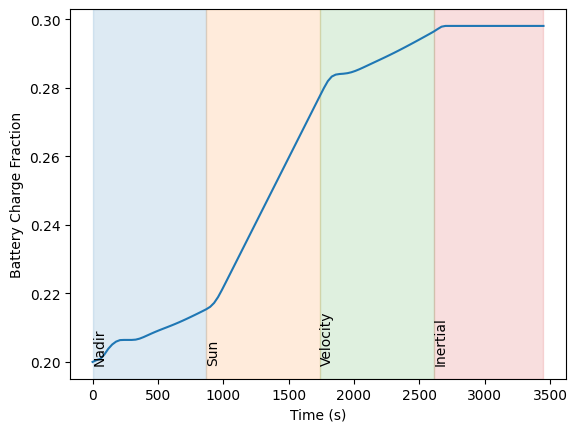

In [11]:
# get the battery data
df_battery = simulation.query_dataframe(battery.get_message("Out_BatteryMsg"))

# plot the battery capacity
fig, ax = plt.subplots()
ax.plot(df_battery.loc[:, "Time"], df_battery.loc[:, "ChargeFraction"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Battery Charge Fraction")


# add the background shading for the operations mode
df_ops_modes = simulation.query_dataframe(computer.get_message("Out_GuidanceChainMsg"))
# get the rows where the mode changes
df_ops_modes_diff = df_ops_modes[df_ops_modes["PointingMode"] != df_ops_modes["PointingMode"].shift(1)]
for i in range(0, len(df_ops_modes_diff)):
    if i == len(df_ops_modes_diff) - 1:
        x = df_ops_modes_diff.loc[:, "Time"].iloc[i]
        y = df_ops_modes.loc[:, "Time"].iloc[-1]
    else:
        x = df_ops_modes_diff.loc[:, "Time"].iloc[i]
        y = df_ops_modes_diff.loc[:, "Time"].iloc[i+1]
        
    ax.axvspan(x, y, color=f"C{i}", alpha=0.15)
    # annotate the mode, placing the text at the left edge of the shaded region
    min_x = np.min(df_battery.loc[:, "ChargeFraction"])
    ax.text(df_ops_modes_diff.loc[:, "Time"].iloc[i], min_x, df_ops_modes_diff.loc[:, "PointingMode"].iloc[i], rotation=90)

plt.show()

### Plotting the solar panel power generation
When we plot the solar panel power generation we expect to see changes in the power generation based on the changing exposure of the solar panels to the Sun due to changes in the spacecraft's pointing mode and its orbit. We can see oscillations in the spacecraft's orbit due to attitude overshoots and corrections. Each colored section of the plot represents a different pointing mode, with the pointing mode annotated on the plot.

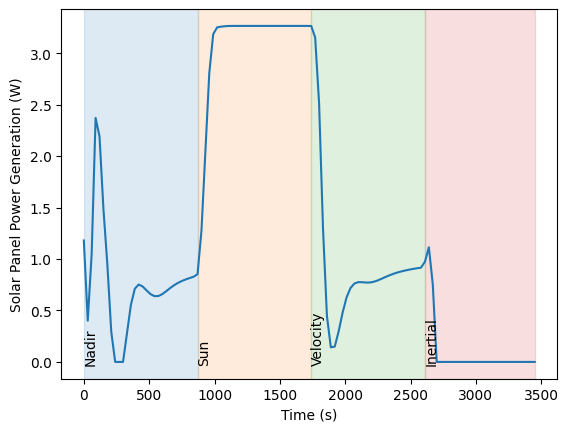

In [12]:
# get the solar panel data
df_solar_panel = simulation.query_dataframe(solar_panel.get_message("Out_PowerSourceMsg"))

# plot the solar panel power generation
fig, ax = plt.subplots()
ax.plot(df_solar_panel.loc[:, "Time"], df_solar_panel.loc[:, "Power"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Solar Panel Power Generation (W)")

# add the background shading for the operations mode
df_ops_modes = simulation.query_dataframe(computer.get_message("Out_GuidanceChainMsg"))
# get the rows where the mode changes
df_ops_modes_diff = df_ops_modes[df_ops_modes["PointingMode"] != df_ops_modes["PointingMode"].shift(1)]
for i in range(0, len(df_ops_modes_diff)):
    if i == len(df_ops_modes_diff) - 1:
        x = df_ops_modes_diff.loc[:, "Time"].iloc[i]
        y = df_ops_modes.loc[:, "Time"].iloc[-1]
    else:
        x = df_ops_modes_diff.loc[:, "Time"].iloc[i]
        y = df_ops_modes_diff.loc[:, "Time"].iloc[i+1]
        
    ax.axvspan(x, y, color=f"C{i}", alpha=0.15)
    # annotate the mode, placing the text at the left edge of the shaded region
    min_x = np.min(df_solar_panel.loc[:, "Power"])
    ax.text(df_ops_modes_diff.loc[:, "Time"].iloc[i], min_x, df_ops_modes_diff.loc[:, "PointingMode"].iloc[i], rotation=90)